## Object Detection

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 1. SIFT matching

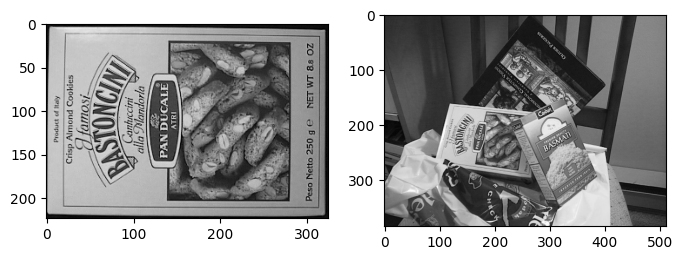

In [9]:
# Open and show images
img1 = cv2.imread('box.png')
img2 = cv2.imread('box_in_scene.png')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img1);
ax[1].imshow(img2);

In [10]:
# SIFT feature extracting
sift = cv2.SIFT.create()
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)


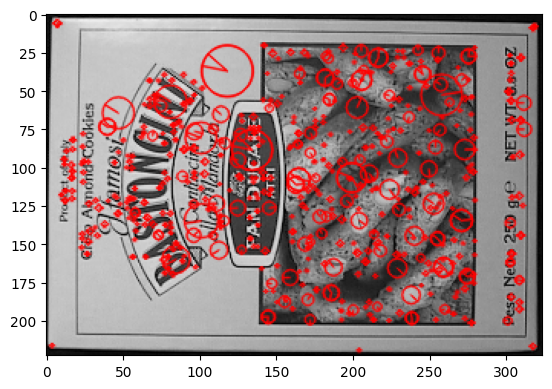

In [18]:
trainImg1=cv2.drawKeypoints(img1, kp1, None, (255,0,0), 4)
plt.imshow(trainImg1);

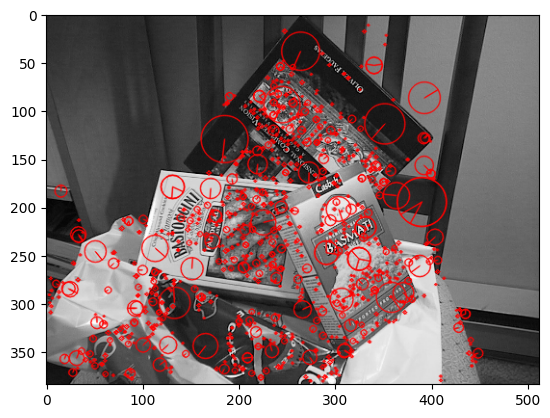

In [19]:
trainImg2=cv2.drawKeypoints(img2, kp2, None, (255,0,0), 4)
plt.imshow(trainImg2);

In [14]:
# BFMatcher(Brute Force Matcher) with defalut setting
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

80 matches


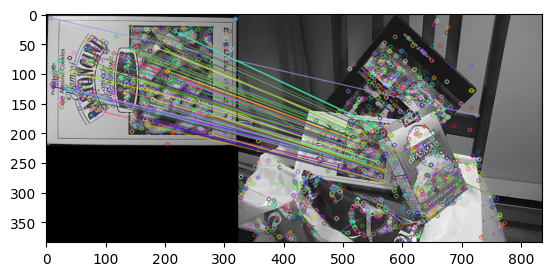

In [16]:
# Apply ratio test as in David Rowe's paper
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
print('%d matches' % len(good_matches))

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB));

### 2. Get Homography Matrix & Object Detection

In [21]:
# Matched points
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

print(src_pts[:3])
print(dst_pts[:3])

[[[  6.894549    6.1633663]]

 [[ 12.016468  121.74898  ]]

 [[ 34.13518   126.633545 ]]]
[[[402.3577  170.31084]]

 [[179.8987  240.98431]]

 [[119.68747 224.40521]]]


In [22]:
# Find homography matrix with RANSAC algorithm
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
print(M)

[[ 4.42477621e-01 -1.63242906e-01  1.18844648e+02]
 [ 1.15364245e-03  4.05117466e-01  1.60919196e+02]
 [-2.43904947e-04 -3.51374227e-04  1.00000000e+00]]


In [23]:
# Calculate the object position in the scene using homography
h,w = img1.shape[0:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
print(dst)

[[[118.84465 160.91919]]

 [[ 89.59347 272.0788 ]]

 [[267.4589  297.94098]]

 [[284.15067 175.08527]]]


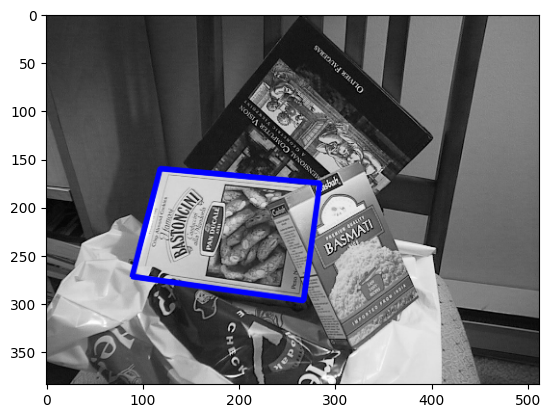

In [25]:
# Display the object
img2 = cv2.polylines(img2,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB));

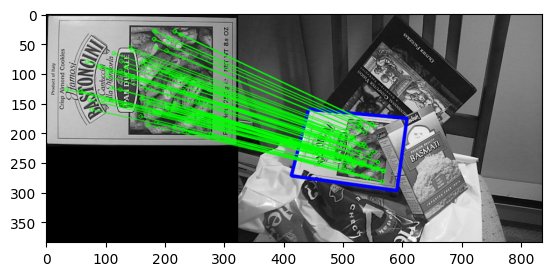

In [26]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,**draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB));